In [1]:
from ekpy import analysis
import numpy as np
import scipy.integrate as it
from scipy.signal import find_peaks, savgol_filter, peak_widths
import matplotlib.pyplot as plt
from ekpy.analysis.analysisgeotemp import use_analysis_file #note need to make this under __all__

In [2]:
# load the dataset
dset = analysis.load_Dataset('./newsampleworksradiant')

# print dset, parsable collection of meta data which holds pointers to the real data files
dset

,initial_delay,pulse_delay,freq,voltage,capacitor_area,thickness,permittivity,amplification,format,type,points,count,x_increment,x_origin,x_reference,y_increment,y_origin,y_reference,trial,filename
0,0.00005,0.000005,10,1,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.01005,0.0,0,0,fe_pv__0.csv
1,0.00005,0.000005,10,1,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.01005,0.0,0,0,fe_pv__1.csv
2,0.00005,0.000005,10,1,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.01005,0.0,0,0,fe_pv__2.csv
3,0.00005,0.000005,10,1,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.01005,0.0,0,0,fe_pv__3.csv
4,0.00005,0.000005,10,1,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.01005,0.0,0,0,fe_pv__4.csv
5,0.00005,0.000005,10,1,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.01005,0.0,0,0,fe_pv__5.csv


In [3]:
data2= dset.select_index(0).get_data()

In [4]:
data2.data_keys

['time_v', 'wfm_v', 'time_c', 'wfm_c']

['Unmodified', 'find_peaks_troughs_index', 'start_and_end_pulse', 'generate_q_wfm', 'drift_correct_q']
['original', 'peaks', 'start_and_end_pulse', 'wfm_q', 'wfm_q']


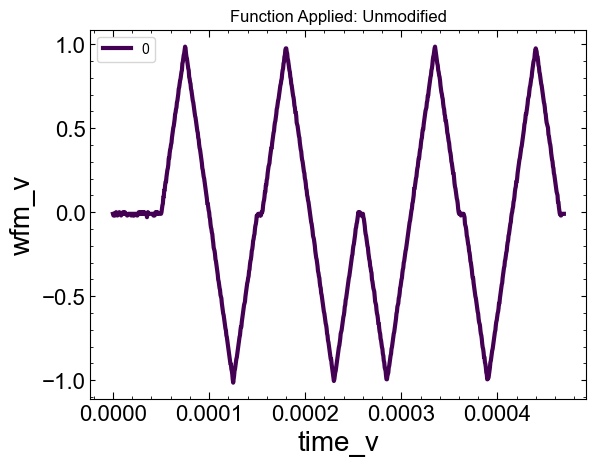

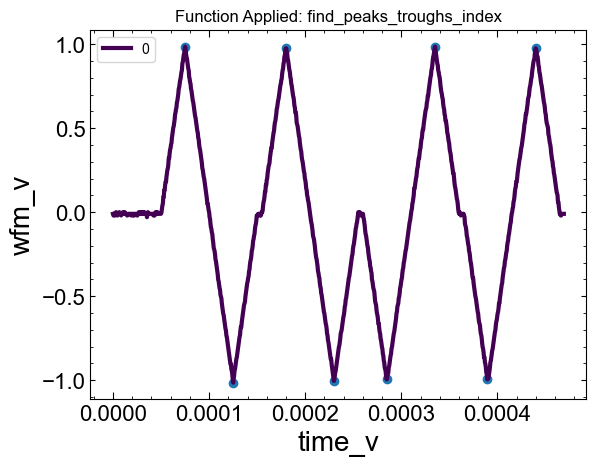

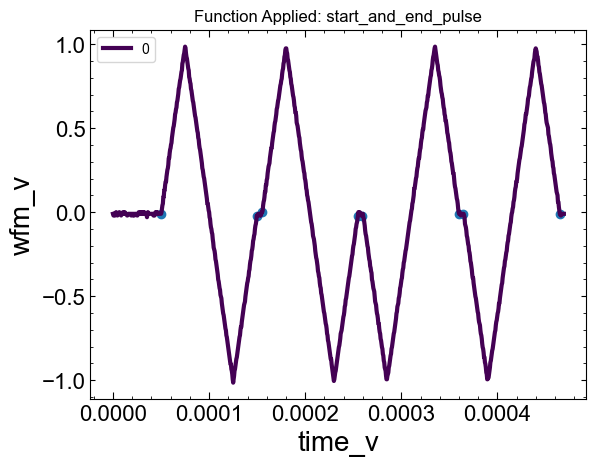

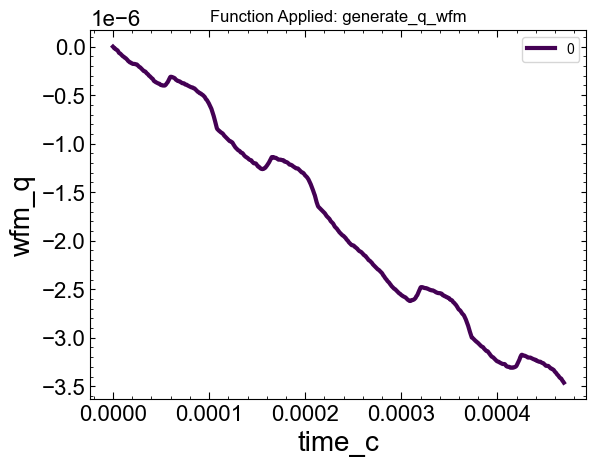

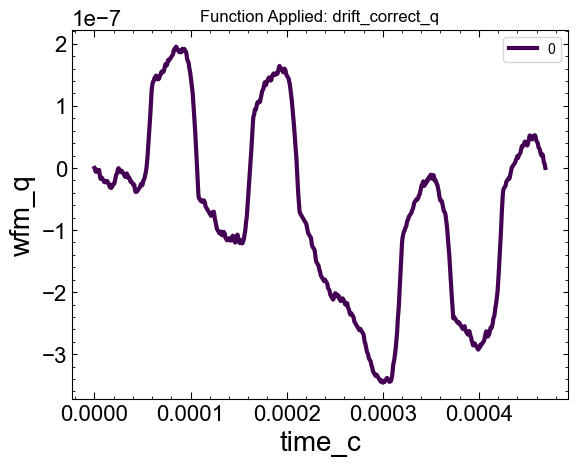

In [5]:
modified_data, interm_steps = use_analysis_file('analysisfile', data2, verbose=True)

In [10]:
modified_data.data_keys

['time_v', 'wfm_v', 'time_c', 'wfm_c', 'wfm_q']

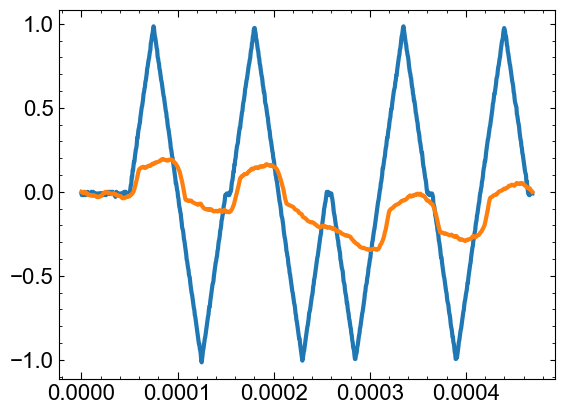

In [22]:
fig, ax = plt.subplots()
ax.plot(modified_data.time_v, modified_data.wfm_v)
ax.plot(modified_data.time_c, 1e6*modified_data.wfm_q)
#showcase delay difference caused by not being synced up (due to the fact that the wavegen does not output chnnl 1 and 2 simulatensouly) maybe there is a way to sync it
#could maybe incorporate a final_delay as opposed to initial delay (or just disregard final pulse)
#ANOTHER POSSIBLE FIX IS TRY TO MOVE THE WF MORE OVER SO WE HAVE MORE SAFETY NET ON BOTH SIDES

In [7]:
complete = interm_steps[list(interm_steps.keys())[-1]]

In [8]:
complete.data_keys

['time_v', 'wfm_v', 'time_c', 'wfm_c', 'peaks', 'start_and_end_pulse', 'wfm_q']

In [ ]:
#want to plot y vs x (polarization[q] vs wfm_v)
complete.wfm_q
complete.start_and_end_pulse

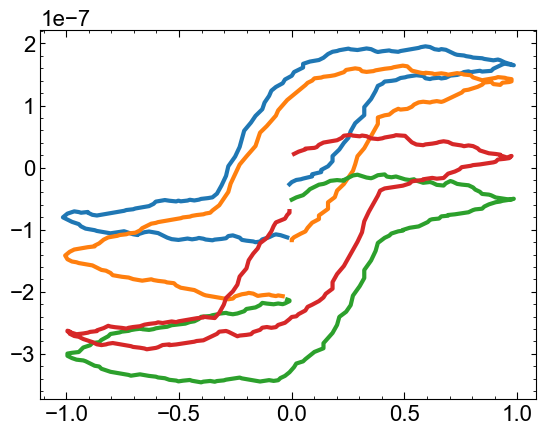

In [9]:
i = 0
while i < len(complete.start_and_end_pulse):
    start = complete.start_and_end_pulse[i]
    end = complete.start_and_end_pulse[i+1]
    plt.plot(complete.wfm_v[start:end], complete.wfm_q[start:end])
    i += 2


Next part we will try to normalize all 4 loops on top of each other by setting the value at -1volts equal for all 4 (based on the first loop) and shift the rest up from there